# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

  Using cached https://files.pythonhosted.org/packages/f5/f0/9da3ef24ea7eb0ccd12430a261b66eca36b924aeef06e17147f9f9d7d310/matplotlib-2.0.2.tar.gz
    Complete output from command python setup.py egg_info:
    Edit setup.cfg to change the build options
    
    BUILDING MATPLOTLIB
                matplotlib: yes [2.0.2]
                    python: yes [3.7.3 (default, Mar 27 2019, 17:13:21) [MSC
                            v.1915 64 bit (AMD64)]]
                  platform: yes [win32]
    
    REQUIRED DEPENDENCIES AND EXTENSIONS
                     numpy: yes [version 1.16.2]
                       six: yes [using six version 1.12.0]
                  dateutil: yes [using dateutil version 2.8.0]
               functools32: yes [Not required]
              subprocess32: yes [Not required]
                      pytz: yes [using pytz version 2018.9]
                    cycler: yes [using cycler version 0.10.0]
                   tornado: yes [using tornado version 6.0.2]
               

Command "python setup.py egg_info" failed with error code 1 in C:\Users\纯\AppData\Local\Temp\pip-install-iv5wpk5x\matplotlib\


Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

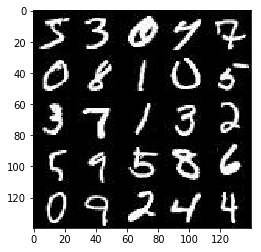

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

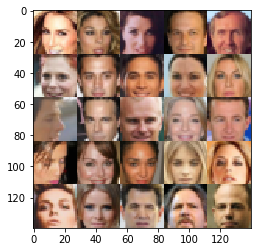

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.14.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width,image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z') 
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

W0926 19:28:13.216148 15956 deprecation_wrapper.py:119] From E:\SDC_Pros\DeepLearning\04_face-generation\problem_unittests.py:20: The name tf.assert_rank is deprecated. Please use tf.compat.v1.assert_rank instead.



Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [31]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images,64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha *x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha *x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha *x3, x3)
        
        flat = tf.reshape(x3, (-1,7*7*256))
        logits = tf.layers.dense(flat, 1)
     
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [32]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha *x1, x1)#leaky relu
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha *x2, x2)
     
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha *x3, x3)
      
#         x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
#         x4 = tf.layers.batch_normalization(x4, training=is_train)
#         x4 = tf.maximum(alpha *x4, x4)
    
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')

        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

W0926 19:31:11.331158 15956 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [35]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [33]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    samples, losses = [], []
    steps = 0    
#     out_channel_dim = 3 if(data_image_mode == "RGB") else 1
    
#     input_real, batch_z, learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2.0
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real:batch_images,lr:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    gen_samples = sess.run(generator(input_z,data_shape[3], is_train=False),
                                          feed_dict={input_z:batch_z})
                    samples.append(gen_samples)
#                     _ = view_s
                    show_generator_output(sess,25,input_z, data_shape[3], data_image_mode)
        saver.save(sess, './checkpoints/generator.ckpt')   
        
        return losses, samples  
        
                              
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.1220... Generator Loss: 0.7148...
Epoch 1/2... Discriminator Loss: 4.8676... Generator Loss: 0.0188...
Epoch 1/2... Discriminator Loss: 2.4610... Generator Loss: 0.1408...
Epoch 1/2... Discriminator Loss: 1.8612... Generator Loss: 0.4543...
Epoch 1/2... Discriminator Loss: 2.0071... Generator Loss: 0.2082...
Epoch 1/2... Discriminator Loss: 1.4862... Generator Loss: 0.4400...
Epoch 1/2... Discriminator Loss: 1.6792... Generator Loss: 0.3034...
Epoch 1/2... Discriminator Loss: 1.5338... Generator Loss: 1.6894...
Epoch 1/2... Discriminator Loss: 1.5061... Generator Loss: 1.4162...
Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 1.0756...


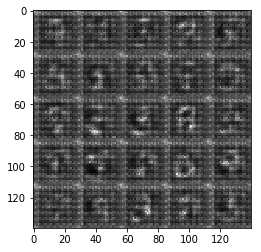

Epoch 1/2... Discriminator Loss: 1.4219... Generator Loss: 1.9617...
Epoch 1/2... Discriminator Loss: 1.1902... Generator Loss: 1.4812...
Epoch 1/2... Discriminator Loss: 1.1227... Generator Loss: 1.2330...
Epoch 1/2... Discriminator Loss: 1.5548... Generator Loss: 0.3731...
Epoch 1/2... Discriminator Loss: 1.3338... Generator Loss: 0.4202...
Epoch 1/2... Discriminator Loss: 1.2767... Generator Loss: 1.6368...
Epoch 1/2... Discriminator Loss: 0.8317... Generator Loss: 1.0079...
Epoch 1/2... Discriminator Loss: 0.8716... Generator Loss: 1.0779...
Epoch 1/2... Discriminator Loss: 1.5197... Generator Loss: 0.3088...
Epoch 1/2... Discriminator Loss: 0.9087... Generator Loss: 1.8511...


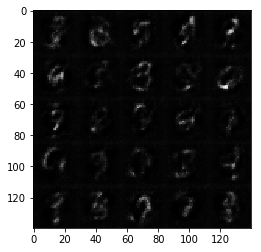

Epoch 1/2... Discriminator Loss: 1.0479... Generator Loss: 1.7801...
Epoch 1/2... Discriminator Loss: 0.8182... Generator Loss: 1.4636...
Epoch 1/2... Discriminator Loss: 1.5543... Generator Loss: 0.2898...
Epoch 1/2... Discriminator Loss: 1.0545... Generator Loss: 0.5522...
Epoch 1/2... Discriminator Loss: 0.7988... Generator Loss: 1.6845...
Epoch 1/2... Discriminator Loss: 1.2948... Generator Loss: 0.3886...
Epoch 1/2... Discriminator Loss: 0.6631... Generator Loss: 1.6215...
Epoch 1/2... Discriminator Loss: 0.7855... Generator Loss: 1.4424...
Epoch 1/2... Discriminator Loss: 0.9681... Generator Loss: 2.1597...
Epoch 1/2... Discriminator Loss: 0.7234... Generator Loss: 1.1512...


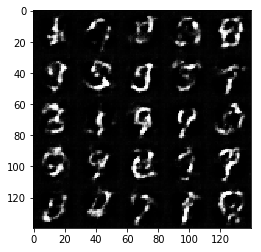

Epoch 1/2... Discriminator Loss: 0.7405... Generator Loss: 1.2406...
Epoch 1/2... Discriminator Loss: 0.7124... Generator Loss: 1.2766...
Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 0.5313...
Epoch 1/2... Discriminator Loss: 1.1447... Generator Loss: 0.5463...
Epoch 1/2... Discriminator Loss: 0.8025... Generator Loss: 1.1528...
Epoch 1/2... Discriminator Loss: 0.8722... Generator Loss: 1.6109...
Epoch 1/2... Discriminator Loss: 1.1766... Generator Loss: 2.0918...
Epoch 1/2... Discriminator Loss: 0.8885... Generator Loss: 0.8134...
Epoch 1/2... Discriminator Loss: 1.0654... Generator Loss: 0.6824...
Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 1.5261...


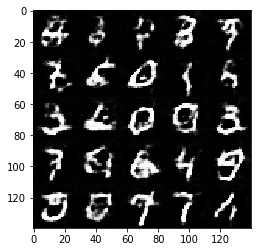

Epoch 1/2... Discriminator Loss: 0.9294... Generator Loss: 1.3545...
Epoch 1/2... Discriminator Loss: 0.9662... Generator Loss: 0.6565...
Epoch 1/2... Discriminator Loss: 0.8732... Generator Loss: 0.8737...
Epoch 1/2... Discriminator Loss: 1.7554... Generator Loss: 0.2885...
Epoch 1/2... Discriminator Loss: 0.9178... Generator Loss: 1.0122...
Epoch 1/2... Discriminator Loss: 0.9842... Generator Loss: 2.0200...
Epoch 2/2... Discriminator Loss: 1.0050... Generator Loss: 0.7543...
Epoch 2/2... Discriminator Loss: 0.8377... Generator Loss: 1.0378...
Epoch 2/2... Discriminator Loss: 1.7655... Generator Loss: 2.3361...
Epoch 2/2... Discriminator Loss: 1.4030... Generator Loss: 0.3706...


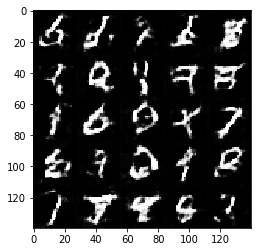

Epoch 2/2... Discriminator Loss: 0.7554... Generator Loss: 1.1510...
Epoch 2/2... Discriminator Loss: 0.8970... Generator Loss: 1.1210...
Epoch 2/2... Discriminator Loss: 1.0132... Generator Loss: 0.6009...
Epoch 2/2... Discriminator Loss: 2.6449... Generator Loss: 0.0913...
Epoch 2/2... Discriminator Loss: 1.1725... Generator Loss: 0.8378...
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 0.8520...
Epoch 2/2... Discriminator Loss: 0.7784... Generator Loss: 1.0543...
Epoch 2/2... Discriminator Loss: 1.1715... Generator Loss: 1.2151...
Epoch 2/2... Discriminator Loss: 1.1294... Generator Loss: 0.5613...
Epoch 2/2... Discriminator Loss: 1.1304... Generator Loss: 0.5675...


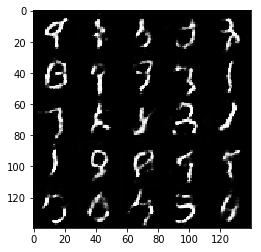

Epoch 2/2... Discriminator Loss: 0.9499... Generator Loss: 0.7305...
Epoch 2/2... Discriminator Loss: 0.7948... Generator Loss: 1.2840...
Epoch 2/2... Discriminator Loss: 1.4799... Generator Loss: 2.5939...
Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 1.8165...
Epoch 2/2... Discriminator Loss: 0.9594... Generator Loss: 0.8508...
Epoch 2/2... Discriminator Loss: 1.1576... Generator Loss: 0.5246...
Epoch 2/2... Discriminator Loss: 0.8430... Generator Loss: 0.8691...
Epoch 2/2... Discriminator Loss: 0.9178... Generator Loss: 0.6924...
Epoch 2/2... Discriminator Loss: 1.2992... Generator Loss: 1.8120...
Epoch 2/2... Discriminator Loss: 1.0617... Generator Loss: 0.7009...


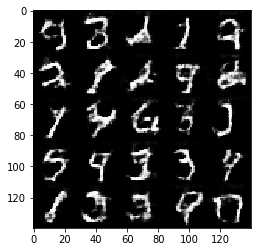

Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 0.7344...
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 1.0032...
Epoch 2/2... Discriminator Loss: 1.4895... Generator Loss: 2.1428...
Epoch 2/2... Discriminator Loss: 0.9669... Generator Loss: 1.3491...
Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 0.7537...
Epoch 2/2... Discriminator Loss: 0.8535... Generator Loss: 0.7680...
Epoch 2/2... Discriminator Loss: 0.9637... Generator Loss: 0.6352...
Epoch 2/2... Discriminator Loss: 1.1236... Generator Loss: 0.7159...
Epoch 2/2... Discriminator Loss: 1.1579... Generator Loss: 0.6305...
Epoch 2/2... Discriminator Loss: 0.8523... Generator Loss: 1.0947...


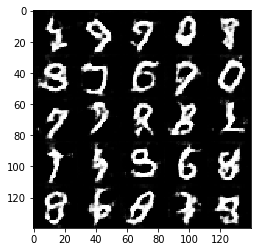

Epoch 2/2... Discriminator Loss: 0.9902... Generator Loss: 1.6937...
Epoch 2/2... Discriminator Loss: 0.9059... Generator Loss: 1.1829...
Epoch 2/2... Discriminator Loss: 2.1454... Generator Loss: 0.1760...
Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 0.7415...
Epoch 2/2... Discriminator Loss: 1.1182... Generator Loss: 0.4956...
Epoch 2/2... Discriminator Loss: 1.3675... Generator Loss: 0.5435...
Epoch 2/2... Discriminator Loss: 1.0842... Generator Loss: 1.1785...
Epoch 2/2... Discriminator Loss: 1.0914... Generator Loss: 0.9915...
Epoch 2/2... Discriminator Loss: 0.9851... Generator Loss: 1.4373...
Epoch 2/2... Discriminator Loss: 1.1458... Generator Loss: 0.5347...


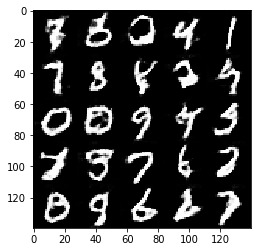

Epoch 2/2... Discriminator Loss: 1.7008... Generator Loss: 0.2883...
Epoch 2/2... Discriminator Loss: 0.7400... Generator Loss: 1.2026...
Epoch 2/2... Discriminator Loss: 1.2451... Generator Loss: 1.9663...


In [36]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4#很重要


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 2.3357... Generator Loss: 0.2908...
Epoch 1/1... Discriminator Loss: 2.4519... Generator Loss: 0.1646...
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.5142...
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 4.5229...
Epoch 1/1... Discriminator Loss: 2.6105... Generator Loss: 0.5337...
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 1.3120...
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 1.0941...
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.6889...
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 1.3591...
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.9150...


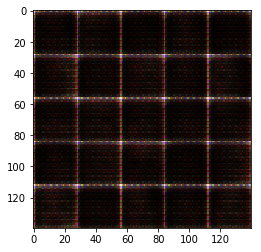

Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 1.9494...
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.0289...
Epoch 1/1... Discriminator Loss: 1.6761... Generator Loss: 0.3165...
Epoch 1/1... Discriminator Loss: 1.8296... Generator Loss: 0.2906...
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 1.6139...
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7870...
Epoch 1/1... Discriminator Loss: 1.6187... Generator Loss: 1.6857...
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.9457...
Epoch 1/1... Discriminator Loss: 1.7841... Generator Loss: 1.0621...
Epoch 1/1... Discriminator Loss: 1.8575... Generator Loss: 0.3213...


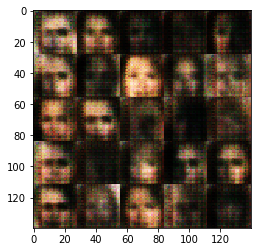

Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.8787...
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.7945...
Epoch 1/1... Discriminator Loss: 1.9765... Generator Loss: 0.2751...
Epoch 1/1... Discriminator Loss: 1.7990... Generator Loss: 0.2736...
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.9853...
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.7996...
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 1.0232...
Epoch 1/1... Discriminator Loss: 1.6145... Generator Loss: 0.7636...
Epoch 1/1... Discriminator Loss: 1.6258... Generator Loss: 0.5066...
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.7000...


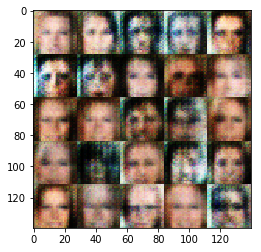

Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.6183...
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.5869...
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.9485...
Epoch 1/1... Discriminator Loss: 1.6449... Generator Loss: 0.3613...
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 1.1474...
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.7583...
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.5405...
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 0.9465...
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 1.1736...
Epoch 1/1... Discriminator Loss: 1.8728... Generator Loss: 0.2726...


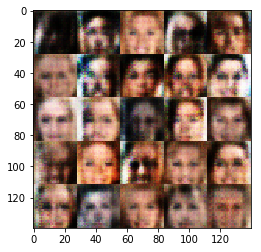

Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.3696...
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.5983...
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 1.4303...
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.8318...
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.5838...
Epoch 1/1... Discriminator Loss: 1.5787... Generator Loss: 0.3320...
Epoch 1/1... Discriminator Loss: 1.7533... Generator Loss: 0.2633...
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.5714...
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 2.4666...
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 1.8433...


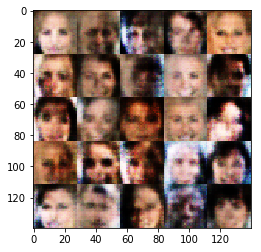

Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.6792...
Epoch 1/1... Discriminator Loss: 1.7142... Generator Loss: 0.2501...
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.4759...
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 3.3227...
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 0.8106...
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 2.4875...
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 1.5685...
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 1.8410...
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 2.2870...
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 1.2323...


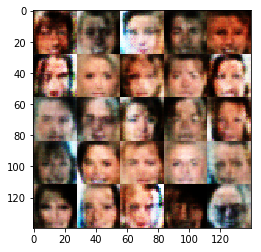

Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.6736...
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 2.3505...
Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 2.9493...
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 2.1161...
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.7103...
Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 2.1600...
Epoch 1/1... Discriminator Loss: 0.6751... Generator Loss: 1.7007...
Epoch 1/1... Discriminator Loss: 1.8059... Generator Loss: 0.2362...
Epoch 1/1... Discriminator Loss: 1.9855... Generator Loss: 0.2096...
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 0.7901...


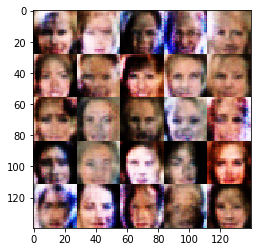

Epoch 1/1... Discriminator Loss: 0.6047... Generator Loss: 2.3635...
Epoch 1/1... Discriminator Loss: 2.3716... Generator Loss: 0.1485...
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.4531...
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.5606...
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 1.5374...
Epoch 1/1... Discriminator Loss: 1.6070... Generator Loss: 0.3305...
Epoch 1/1... Discriminator Loss: 1.5738... Generator Loss: 2.1291...
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.3585...
Epoch 1/1... Discriminator Loss: 0.5383... Generator Loss: 3.0975...
Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 2.4756...


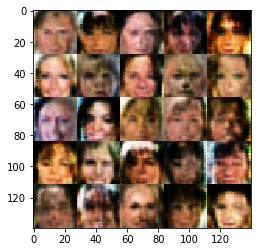

Epoch 1/1... Discriminator Loss: 0.6853... Generator Loss: 2.4012...
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.5916...
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 2.0650...
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 0.7154...
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 1.0606...
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 3.0974...
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 2.2524...
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.4849...
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 3.0151...
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.4170...


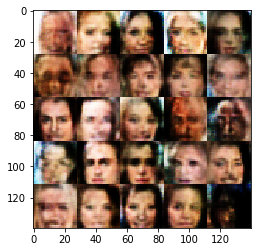

Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 1.4684...
Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 3.3979...
Epoch 1/1... Discriminator Loss: 1.5536... Generator Loss: 4.8918...
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 5.9862...
Epoch 1/1... Discriminator Loss: 0.4565... Generator Loss: 1.4453...
Epoch 1/1... Discriminator Loss: 0.4235... Generator Loss: 1.7997...
Epoch 1/1... Discriminator Loss: 0.7490... Generator Loss: 0.8477...
Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 1.9920...
Epoch 1/1... Discriminator Loss: 0.5356... Generator Loss: 1.2018...
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 4.6786...


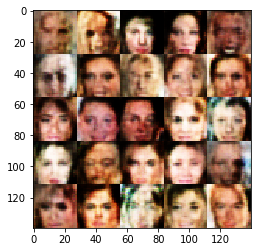

Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 5.6010...
Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 0.7746...
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 3.1122...
Epoch 1/1... Discriminator Loss: 0.4917... Generator Loss: 1.5867...
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 2.3496...
Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 1.3569...
Epoch 1/1... Discriminator Loss: 0.2794... Generator Loss: 1.9990...
Epoch 1/1... Discriminator Loss: 0.1991... Generator Loss: 4.1902...
Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 1.1969...
Epoch 1/1... Discriminator Loss: 0.2238... Generator Loss: 2.9170...


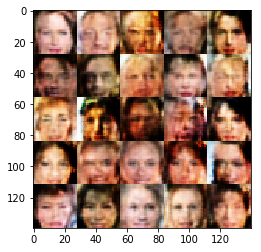

Epoch 1/1... Discriminator Loss: 0.2834... Generator Loss: 3.8719...
Epoch 1/1... Discriminator Loss: 0.3653... Generator Loss: 3.3286...
Epoch 1/1... Discriminator Loss: 0.6766... Generator Loss: 0.9785...
Epoch 1/1... Discriminator Loss: 0.2549... Generator Loss: 2.4203...
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 0.8273...
Epoch 1/1... Discriminator Loss: 0.1579... Generator Loss: 3.0380...
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 1.6132...
Epoch 1/1... Discriminator Loss: 0.4546... Generator Loss: 1.3870...
Epoch 1/1... Discriminator Loss: 2.5203... Generator Loss: 2.4585...
Epoch 1/1... Discriminator Loss: 0.1435... Generator Loss: 3.0634...


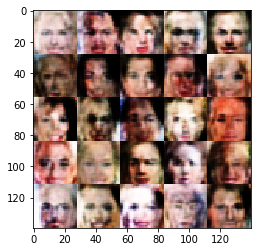

Epoch 1/1... Discriminator Loss: 0.3171... Generator Loss: 4.0808...
Epoch 1/1... Discriminator Loss: 0.2415... Generator Loss: 2.2786...
Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 1.0614...
Epoch 1/1... Discriminator Loss: 0.3540... Generator Loss: 3.3050...
Epoch 1/1... Discriminator Loss: 0.1368... Generator Loss: 4.2525...
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.9492...
Epoch 1/1... Discriminator Loss: 0.1807... Generator Loss: 2.3535...
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 0.6487...
Epoch 1/1... Discriminator Loss: 0.4060... Generator Loss: 5.1409...
Epoch 1/1... Discriminator Loss: 0.1807... Generator Loss: 3.6782...


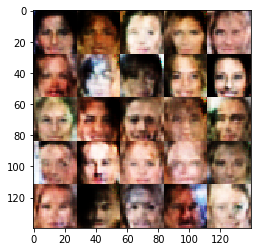

Epoch 1/1... Discriminator Loss: 0.1361... Generator Loss: 3.7821...
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 0.9980...
Epoch 1/1... Discriminator Loss: 0.2426... Generator Loss: 2.5509...
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 6.3872...
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 1.5574...
Epoch 1/1... Discriminator Loss: 0.3561... Generator Loss: 3.9109...
Epoch 1/1... Discriminator Loss: 0.1546... Generator Loss: 2.5978...
Epoch 1/1... Discriminator Loss: 0.2995... Generator Loss: 4.2034...
Epoch 1/1... Discriminator Loss: 0.2443... Generator Loss: 2.3631...
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 4.7831...


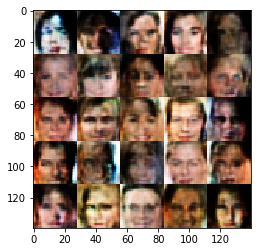

Epoch 1/1... Discriminator Loss: 0.5644... Generator Loss: 2.7470...
Epoch 1/1... Discriminator Loss: 1.8829... Generator Loss: 3.3263...
Epoch 1/1... Discriminator Loss: 0.3290... Generator Loss: 2.9465...
Epoch 1/1... Discriminator Loss: 0.5372... Generator Loss: 1.1485...
Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 1.7197...
Epoch 1/1... Discriminator Loss: 0.1453... Generator Loss: 3.8248...
Epoch 1/1... Discriminator Loss: 0.4398... Generator Loss: 4.3692...
Epoch 1/1... Discriminator Loss: 0.3171... Generator Loss: 2.1729...
Epoch 1/1... Discriminator Loss: 0.3348... Generator Loss: 1.7030...
Epoch 1/1... Discriminator Loss: 0.2064... Generator Loss: 2.5984...


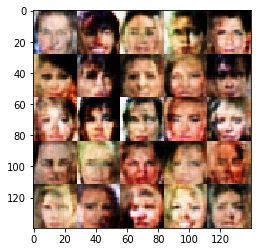

Epoch 1/1... Discriminator Loss: 0.2623... Generator Loss: 3.6420...
Epoch 1/1... Discriminator Loss: 2.6088... Generator Loss: 0.1472...
Epoch 1/1... Discriminator Loss: 0.4921... Generator Loss: 1.3708...
Epoch 1/1... Discriminator Loss: 0.3560... Generator Loss: 1.7224...
Epoch 1/1... Discriminator Loss: 0.2498... Generator Loss: 2.6605...
Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 4.3620...
Epoch 1/1... Discriminator Loss: 0.3320... Generator Loss: 1.6963...
Epoch 1/1... Discriminator Loss: 0.1205... Generator Loss: 4.3610...
Epoch 1/1... Discriminator Loss: 0.2250... Generator Loss: 2.5157...
Epoch 1/1... Discriminator Loss: 0.1345... Generator Loss: 6.1577...


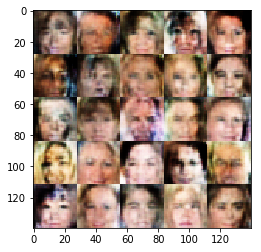

Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 4.1053...
Epoch 1/1... Discriminator Loss: 2.2828... Generator Loss: 1.9482...
Epoch 1/1... Discriminator Loss: 0.2269... Generator Loss: 2.6252...
Epoch 1/1... Discriminator Loss: 0.4599... Generator Loss: 3.2114...
Epoch 1/1... Discriminator Loss: 0.2157... Generator Loss: 3.1794...
Epoch 1/1... Discriminator Loss: 0.4801... Generator Loss: 1.2902...
Epoch 1/1... Discriminator Loss: 0.2892... Generator Loss: 2.1660...
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 3.5541...
Epoch 1/1... Discriminator Loss: 0.1073... Generator Loss: 4.4457...
Epoch 1/1... Discriminator Loss: 0.2348... Generator Loss: 2.3712...


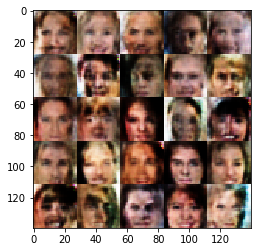

Epoch 1/1... Discriminator Loss: 0.1704... Generator Loss: 3.6187...
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 4.8844...
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 0.9966...
Epoch 1/1... Discriminator Loss: 0.1136... Generator Loss: 3.3249...
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 3.5993...
Epoch 1/1... Discriminator Loss: 0.5278... Generator Loss: 6.1734...
Epoch 1/1... Discriminator Loss: 0.1691... Generator Loss: 3.8630...
Epoch 1/1... Discriminator Loss: 0.1103... Generator Loss: 3.7398...
Epoch 1/1... Discriminator Loss: 0.3118... Generator Loss: 4.5621...
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 1.7303...


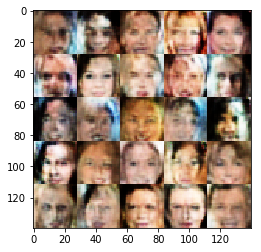

Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 1.2037...
Epoch 1/1... Discriminator Loss: 0.1664... Generator Loss: 3.0979...
Epoch 1/1... Discriminator Loss: 0.1362... Generator Loss: 3.8615...
Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 0.8828...
Epoch 1/1... Discriminator Loss: 0.2729... Generator Loss: 1.9848...
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.4085...
Epoch 1/1... Discriminator Loss: 0.4534... Generator Loss: 4.9136...
Epoch 1/1... Discriminator Loss: 0.2026... Generator Loss: 2.6384...
Epoch 1/1... Discriminator Loss: 0.1378... Generator Loss: 3.7162...
Epoch 1/1... Discriminator Loss: 0.5516... Generator Loss: 2.9105...


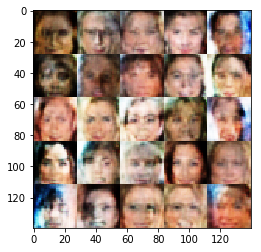

Epoch 1/1... Discriminator Loss: 0.1231... Generator Loss: 4.8297...
Epoch 1/1... Discriminator Loss: 0.1360... Generator Loss: 4.3528...
Epoch 1/1... Discriminator Loss: 0.1114... Generator Loss: 5.9755...
Epoch 1/1... Discriminator Loss: 0.2754... Generator Loss: 1.8611...
Epoch 1/1... Discriminator Loss: 0.3187... Generator Loss: 1.7622...
Epoch 1/1... Discriminator Loss: 0.3292... Generator Loss: 3.2514...
Epoch 1/1... Discriminator Loss: 0.4219... Generator Loss: 1.4754...
Epoch 1/1... Discriminator Loss: 0.0483... Generator Loss: 5.5620...
Epoch 1/1... Discriminator Loss: 2.6385... Generator Loss: 0.1379...
Epoch 1/1... Discriminator Loss: 0.1575... Generator Loss: 3.6958...


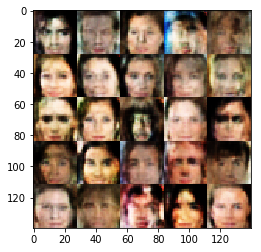

Epoch 1/1... Discriminator Loss: 0.2921... Generator Loss: 4.5122...
Epoch 1/1... Discriminator Loss: 0.2250... Generator Loss: 2.9794...
Epoch 1/1... Discriminator Loss: 0.2333... Generator Loss: 4.6490...
Epoch 1/1... Discriminator Loss: 0.4350... Generator Loss: 6.0106...
Epoch 1/1... Discriminator Loss: 0.2379... Generator Loss: 2.5289...
Epoch 1/1... Discriminator Loss: 0.3025... Generator Loss: 1.8372...
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.4498...
Epoch 1/1... Discriminator Loss: 0.6250... Generator Loss: 3.1713...
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 0.7636...
Epoch 1/1... Discriminator Loss: 0.1936... Generator Loss: 4.5805...


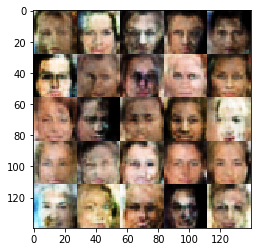

Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 0.8429...
Epoch 1/1... Discriminator Loss: 0.1075... Generator Loss: 4.5580...
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 7.8942...
Epoch 1/1... Discriminator Loss: 0.4784... Generator Loss: 1.3381...
Epoch 1/1... Discriminator Loss: 0.1248... Generator Loss: 4.2833...
Epoch 1/1... Discriminator Loss: 0.4784... Generator Loss: 1.5523...
Epoch 1/1... Discriminator Loss: 0.2583... Generator Loss: 4.6949...
Epoch 1/1... Discriminator Loss: 0.1041... Generator Loss: 3.9384...
Epoch 1/1... Discriminator Loss: 0.1653... Generator Loss: 5.0245...
Epoch 1/1... Discriminator Loss: 0.1762... Generator Loss: 2.9433...


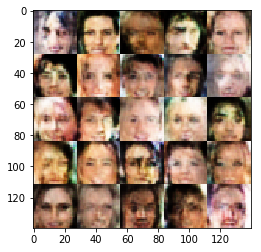

Epoch 1/1... Discriminator Loss: 0.2164... Generator Loss: 4.4602...
Epoch 1/1... Discriminator Loss: 0.1181... Generator Loss: 3.4618...
Epoch 1/1... Discriminator Loss: 0.4522... Generator Loss: 1.2816...
Epoch 1/1... Discriminator Loss: 0.3069... Generator Loss: 1.7918...
Epoch 1/1... Discriminator Loss: 0.1382... Generator Loss: 2.7646...
Epoch 1/1... Discriminator Loss: 0.2866... Generator Loss: 1.9352...
Epoch 1/1... Discriminator Loss: 0.1190... Generator Loss: 3.9308...
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 2.2119...
Epoch 1/1... Discriminator Loss: 0.1542... Generator Loss: 4.2170...
Epoch 1/1... Discriminator Loss: 0.2142... Generator Loss: 2.5226...


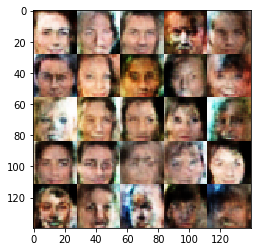

Epoch 1/1... Discriminator Loss: 0.0869... Generator Loss: 5.6835...
Epoch 1/1... Discriminator Loss: 0.0951... Generator Loss: 4.5429...
Epoch 1/1... Discriminator Loss: 0.2003... Generator Loss: 5.5902...
Epoch 1/1... Discriminator Loss: 4.7202... Generator Loss: 6.6017...
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 1.0474...
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.4204...
Epoch 1/1... Discriminator Loss: 0.2855... Generator Loss: 2.6167...
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 2.8295...
Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 0.9264...
Epoch 1/1... Discriminator Loss: 0.1943... Generator Loss: 2.5491...


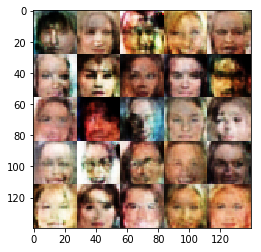

Epoch 1/1... Discriminator Loss: 0.1211... Generator Loss: 4.1309...
Epoch 1/1... Discriminator Loss: 0.1124... Generator Loss: 3.7971...
Epoch 1/1... Discriminator Loss: 0.1434... Generator Loss: 4.4854...
Epoch 1/1... Discriminator Loss: 0.1985... Generator Loss: 2.7043...
Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 1.0917...
Epoch 1/1... Discriminator Loss: 0.1560... Generator Loss: 2.8444...
Epoch 1/1... Discriminator Loss: 0.3045... Generator Loss: 1.7222...
Epoch 1/1... Discriminator Loss: 0.0986... Generator Loss: 3.9418...
Epoch 1/1... Discriminator Loss: 0.1180... Generator Loss: 4.0342...
Epoch 1/1... Discriminator Loss: 0.1141... Generator Loss: 3.0368...


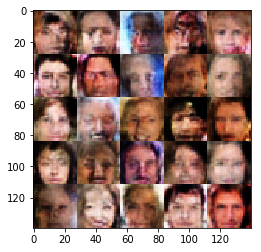

Epoch 1/1... Discriminator Loss: 0.1092... Generator Loss: 5.7054...
Epoch 1/1... Discriminator Loss: 0.0881... Generator Loss: 3.9025...
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 5.7286...
Epoch 1/1... Discriminator Loss: 1.6243... Generator Loss: 0.4432...
Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 1.2030...
Epoch 1/1... Discriminator Loss: 1.6494... Generator Loss: 3.9408...
Epoch 1/1... Discriminator Loss: 0.5927... Generator Loss: 1.5855...
Epoch 1/1... Discriminator Loss: 0.2627... Generator Loss: 2.3634...
Epoch 1/1... Discriminator Loss: 0.2057... Generator Loss: 2.4358...
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.4419...


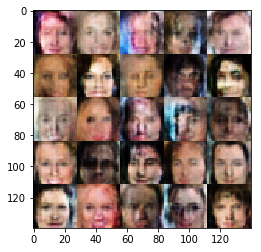

Epoch 1/1... Discriminator Loss: 2.7175... Generator Loss: 4.3217...
Epoch 1/1... Discriminator Loss: 0.1759... Generator Loss: 2.5402...
Epoch 1/1... Discriminator Loss: 0.4545... Generator Loss: 4.8887...
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 1.1118...
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 5.1670...
Epoch 1/1... Discriminator Loss: 0.2533... Generator Loss: 1.9986...
Epoch 1/1... Discriminator Loss: 0.3190... Generator Loss: 3.0101...
Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 0.9444...
Epoch 1/1... Discriminator Loss: 0.2386... Generator Loss: 2.2183...
Epoch 1/1... Discriminator Loss: 0.0516... Generator Loss: 5.2913...


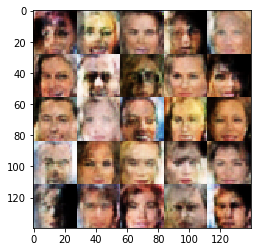

Epoch 1/1... Discriminator Loss: 0.2183... Generator Loss: 2.0957...
Epoch 1/1... Discriminator Loss: 0.2076... Generator Loss: 4.0880...
Epoch 1/1... Discriminator Loss: 0.2006... Generator Loss: 2.1190...
Epoch 1/1... Discriminator Loss: 0.1418... Generator Loss: 4.6789...
Epoch 1/1... Discriminator Loss: 0.0715... Generator Loss: 4.5494...
Epoch 1/1... Discriminator Loss: 0.1097... Generator Loss: 2.9879...
Epoch 1/1... Discriminator Loss: 0.1424... Generator Loss: 4.5475...
Epoch 1/1... Discriminator Loss: 0.1645... Generator Loss: 2.9827...
Epoch 1/1... Discriminator Loss: 0.1186... Generator Loss: 3.0981...
Epoch 1/1... Discriminator Loss: 0.4360... Generator Loss: 1.5530...


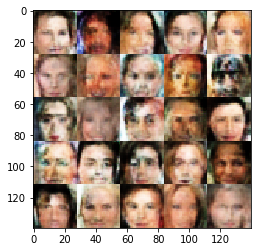

Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 1.2617...
Epoch 1/1... Discriminator Loss: 0.1650... Generator Loss: 2.6100...
Epoch 1/1... Discriminator Loss: 0.1011... Generator Loss: 4.1313...
Epoch 1/1... Discriminator Loss: 0.0745... Generator Loss: 3.7847...
Epoch 1/1... Discriminator Loss: 0.1396... Generator Loss: 3.6150...
Epoch 1/1... Discriminator Loss: 0.0976... Generator Loss: 4.1323...
Epoch 1/1... Discriminator Loss: 3.9453... Generator Loss: 6.3327...
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 3.1839...
Epoch 1/1... Discriminator Loss: 0.2292... Generator Loss: 2.1755...
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 0.5530...


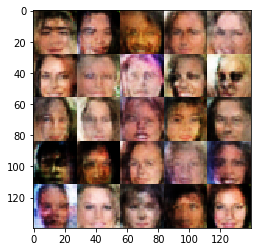

Epoch 1/1... Discriminator Loss: 0.3096... Generator Loss: 1.7920...
Epoch 1/1... Discriminator Loss: 0.1050... Generator Loss: 4.9025...
Epoch 1/1... Discriminator Loss: 0.0649... Generator Loss: 4.1303...
Epoch 1/1... Discriminator Loss: 0.1058... Generator Loss: 4.0217...
Epoch 1/1... Discriminator Loss: 1.7762... Generator Loss: 0.2943...
Epoch 1/1... Discriminator Loss: 0.5512... Generator Loss: 1.3901...
Epoch 1/1... Discriminator Loss: 2.9760... Generator Loss: 0.1310...
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 0.8771...
Epoch 1/1... Discriminator Loss: 0.1839... Generator Loss: 2.5369...
Epoch 1/1... Discriminator Loss: 0.2689... Generator Loss: 2.0722...


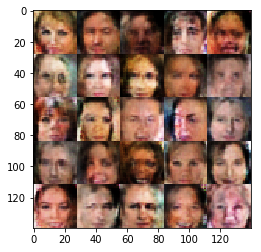

Epoch 1/1... Discriminator Loss: 0.2716... Generator Loss: 5.3984...
Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 1.1833...
Epoch 1/1... Discriminator Loss: 0.1990... Generator Loss: 3.8347...
Epoch 1/1... Discriminator Loss: 0.0860... Generator Loss: 4.5940...
Epoch 1/1... Discriminator Loss: 0.0740... Generator Loss: 3.3358...
Epoch 1/1... Discriminator Loss: 0.1008... Generator Loss: 3.1094...
Epoch 1/1... Discriminator Loss: 0.3707... Generator Loss: 1.4527...
Epoch 1/1... Discriminator Loss: 0.4082... Generator Loss: 3.7437...
Epoch 1/1... Discriminator Loss: 0.0828... Generator Loss: 8.0106...
Epoch 1/1... Discriminator Loss: 0.1187... Generator Loss: 3.6269...


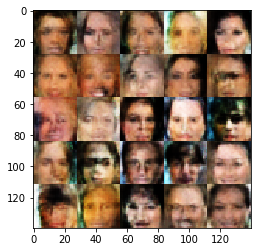

Epoch 1/1... Discriminator Loss: 0.1113... Generator Loss: 5.8740...
Epoch 1/1... Discriminator Loss: 0.0509... Generator Loss: 4.8222...
Epoch 1/1... Discriminator Loss: 1.9618... Generator Loss: 0.2844...
Epoch 1/1... Discriminator Loss: 0.4313... Generator Loss: 2.2674...
Epoch 1/1... Discriminator Loss: 0.5991... Generator Loss: 1.5011...
Epoch 1/1... Discriminator Loss: 0.1719... Generator Loss: 3.6430...


In [37]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。